# Import needed libaries

In [1]:
import numpy as np
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt

# Import MNIST Dataset

In [2]:
# https://www.kaggle.com/code/hojjatk/read-mnist-dataset

# MNIST Data Loader Class

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

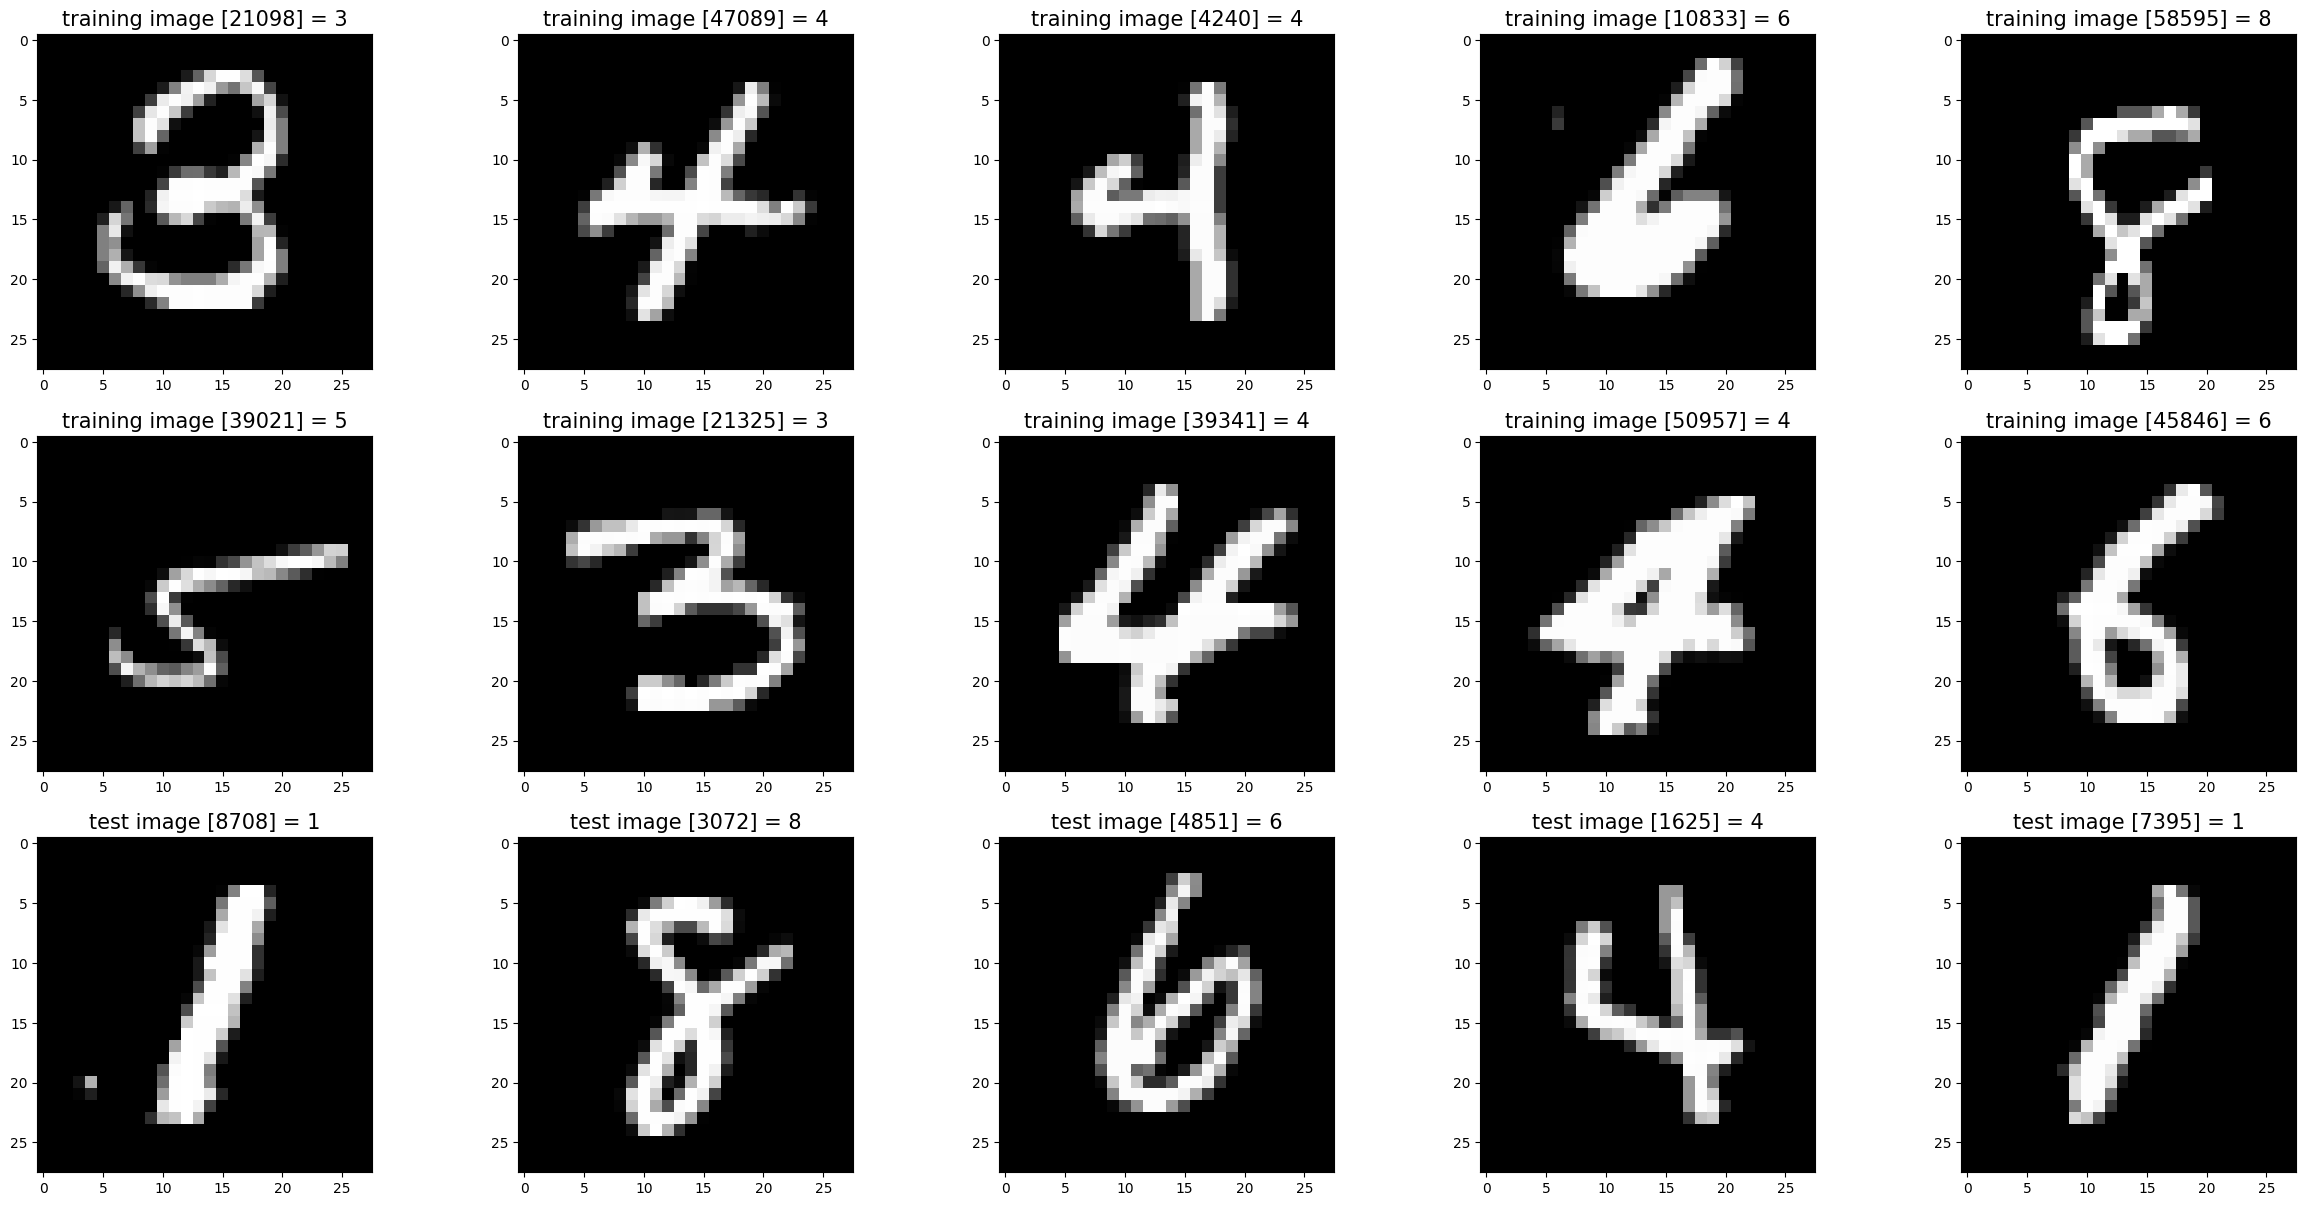

In [3]:
# Set file paths based on added MNIST Datasets

training_images_filepath = ('train_images.idx3-ubyte')
training_labels_filepath = ('train_labels.idx1-ubyte')
test_images_filepath = ('test_images.idx3-ubyte')
test_labels_filepath = ('test_labels.idx1-ubyte')

# Helper function to show a list of images with their relating titles

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

#### Filter for just '1'

In [4]:
# Filter training and test sets for images and labels corresponding to the digit '1'
x_train_1 = x_train[y_train == 1]
y_train_1 = y_train[y_train == 1]

x_test_1 = x_test[y_test == 1]
y_test_1 = y_test[y_test == 1]

print(f"Number of training images labeled '1': {len(x_train_1)}")
print(f"Number of test images labeled '1': {len(x_test_1)}")

Number of training images labeled '1': 28
Number of test images labeled '1': 28
